## 1. Problema que as GRUs resolvem
Redes RNN simples (vanilla RNN) têm dificuldade em aprender dependências de longo prazo devido ao **problema do gradiente** (vanishing/exploding). Como consequência, sinais de erro se atenuam ao propagar-se por muitas etapas temporais, impedindo que a rede retenha informação relevante de passos distantes.

**GRUs** introduzem mecanismos de **portas (gates)** que controlam o fluxo de informação ao longo do tempo, permitindo que a rede:

* preserve informações úteis por muitos passos (mitigando *vanishing gradients*),
* atualize o estado apenas quando necessário (reduzir ruído e facilitar aprendizagem de dependências longas),
* treine mais eficientemente (menos parâmetros que LSTM em muitos casos).

---

## 2. Em que consiste o método — descrição e componentes-chave

GRU é uma unidade recorrente com duas portas principais — **update gate** (porta de atualização) e **reset gate** (porta de redefinição) — e um estado oculto único (sem um estado de célula separado como em LSTM).

## Notação
* $x_t$ : entrada no tempo $t$
* $h_{t-1}$ : estado oculto no tempo $t-1$
* $z_t$ : update gate (vetor)
* $r_t$ : reset gate (vetor)
* $\tilde{h}_t$ : candidato de novo estado oculto
* $h_t$ : estado oculto no tempo $t$
* $W_*, U_*, b_*$ : pesos e vieses aprendíveis

## Equações (padrão)

$$
\begin{aligned}
z_t &= \sigma(W_z x_t + U_z h_{t-1} + b_z) \quad\text{(update gate)}\\[6pt]
r_t &= \sigma(W_r x_t + U_r h_{t-1} + b_r) \quad\text{(reset gate)}\\[6pt]
\tilde{h}_t &= \tanh\big(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h\big) \quad\text{(candidato)}\\[6pt]
h_t &= z_t \odot h_{t-1} + (1 - z_t) \odot \tilde{h}_t \quad\text{(interpolação)}
\end{aligned}
$$

* $\sigma$ é a sigmoide; $\odot$ produto elemento-a-elemento.
* Interpretação: se $z_t$ próximo de 1 → mantém $h_{t-1}$; se $z_t$ próximo de 0 → adota $\tilde{h}_t$.

## Intuição operacional
* **Reset gate ($r_t$)**: controla quanto do estado anterior contribuirá para calcular o candidato $\tilde{h}_t$. Se $r_t$ é pequeno, a rede "esquece" partes do passado ao calcular o candidato — útil para dependências curtas.
* **Update gate ($z_t$)**: decide quanto do estado antigo deve ser mantido vs. substituído pelo novo candidato. Atua como uma mistura entre memórias antigas e novas.

## 3. Vantagens e desvantagens (comparações objetivas)
### vs RNN simples (vanilla)

**Vantagens GRU**

* Resolução parcial do *vanishing gradient* via caminhos de curto-circuito pelas portas.
* Capacidade de capturar dependências de longo prazo com menos dificuldade.
* Melhor desempenho empírico em muitas tarefas sequenciais.

**Desvantagens GRU**

* Estrutura mais complexa → mais custo computacional por célula que RNN simples.
* Requer cuidado com hiperparâmetros e regularização.
### vs LSTM

**Semelhanças**

* Ambos usam portas e mitigam problemas das RNNs simples.
* Ambos aptos para dependências longas.

**Diferenças principais**

* **Complexidade**: LSTM tem 3 portas (input, forget, output) + estado de célula (c_t); GRU tem 2 portas e um único estado oculto. Logo, **GRU tem menos parâmetros**.
* **Velocidade/treino**: GRU tende a treinar mais rápido e generalizar de forma semelhante em muitos problemas; útil quando recursos computacionais são limitados.
* **Capacidade**: LSTM pode modelar dinâmicas mais complexas devido ao estado de célula separado — às vezes supera GRU em tarefas que exigem modelagem muito longa/complexa.
* **Simplicidade vs Controle**: LSTM fornece controle mais fino (forget gate explícito, output gate), GRU é mais compacto e menos paramétrico.

**Quando preferir cada um**

* Preferir **GRU** quando: dataset moderado, rapidez/recursos importam, desempenho comparável esperado.
* Preferir **LSTM** quando: dependências extremamente longas e complexas são críticas, e recursos permitem mais parâmetros.

---


## 4. Aplicações comuns
GRUs são amplamente usadas em problemas sequenciais, exemplo não-exaustivo:

* **Processamento de linguagem natural (NLP)**

  * Classificação de texto (sentiment analysis), etiquetagem seq2seq (NER), modelagem de linguagem, geração de texto (como parte de RNNs).
* **Machine translation** (em encoder-decoders; muitas variantes usam GRU em encoder/decoder).
* **Séries temporais**

  * Previsão de séries financeiras, sensoriais, dados IoT.
* **Reconhecimento de fala**

  * Extração de características temporais, modelos acústicos.
* **Análise de sequência em bioinformática**

  * Modelagem de sequências de bases/proteínas.
* **Qualquer tarefa seq-to-one ou seq-to-seq** com dependências temporais.

---

## 5. Observações práticas de implementação (TensorFlow / PyTorch) — pontos essenciais e armadilhas
**Imports e tipos**

* Use `Embedding` + GRU para texto. Garanta `mask_zero=True` no Embedding se usar padding com 0, ou use `masking` explícito.
* Para classificação binária: ativação `sigmoid` com `binary_crossentropy`; multiclasses: `softmax` + `categorical_crossentropy`.

**Performance**

* Em TensorFlow/Keras, certas combinações (ex.: `recurrent_dropout` ≠ 0 ou uso de máscara específica) podem desabilitar a implementação acelerada (CuDNN) e deixar o GRU mais lento na GPU. Se a velocidade for crítica, evite `recurrent_dropout` e use as implementações otimizadas (ou `GRU(..., reset_after=True)` dependendo da versão).
* `return_sequences=True` quando se precisa da saída em cada passo (p.ex. seq2seq ou camadas subsequentes LSTM/GRU/Bidirectional). Caso contrário, `return_sequences=False` para saída final apenas.

**Regularização e estabilidade**

* `Dropout` (entrada) e `recurrent_dropout` (estado recorrente) ajudam a reduzir overfitting; porém, `recurrent_dropout` pode desativar otimizações.
* **Gradient clipping** (por valor ou norma) é recomendado para evitar *exploding gradients* em tarefas longas.
* Inicializadores (Glorot/Xavier para pesos, zeros para vieses geralmente) e normalização de entradas ajudam convergência.

**Arquitetura**

* **Stacking**: empilhar múltiplas camadas GRU pode aumentar capacidade, mas aumentar risco de overfitting e custo computacional.
* **Bidirecional**: `Bidirectional(GRU(...))` permite capturar contexto futuro e passado — útil em tarefas onde a sequência completa é conhecida.
* **Attention**: em seq2seq, combinar GRU com mecanismos de atenção melhora desempenho em tradução e resumo.

**Hiperparâmetros importantes para ajustar**

* Número de unidades (hidden size) da GRU.
* Tamanho do embedding (para NLP).
* `SEQ_LEN` (tamanho de sequência), `VOCAB_SIZE`.
* `batch_size`, `learning_rate`, otimizador (Adam costuma funcionar bem).
* Dropout rates, `recurrent_dropout` (com cuidado).

**Treinamento**

* Monitorar validação (val_loss, val_auc/val_acc).
* Use `EarlyStopping` com `restore_best_weights=True`.
* Salvar checkpoints (`ModelCheckpoint`) para retomar/avaliar melhores pesos.

---


## OUTPUTS E PARAMETROS DO MODELO

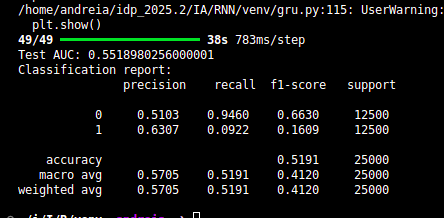

output 1

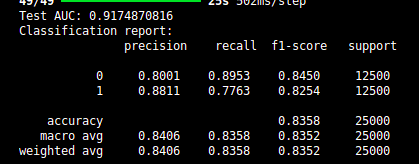

output 2

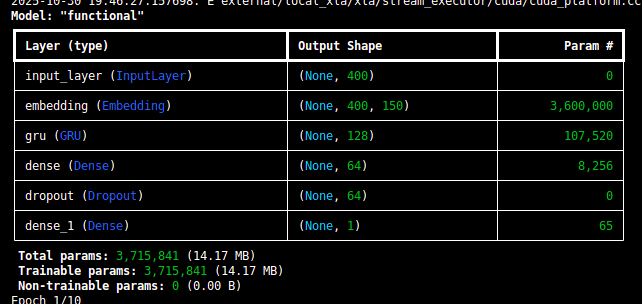

parametros 1

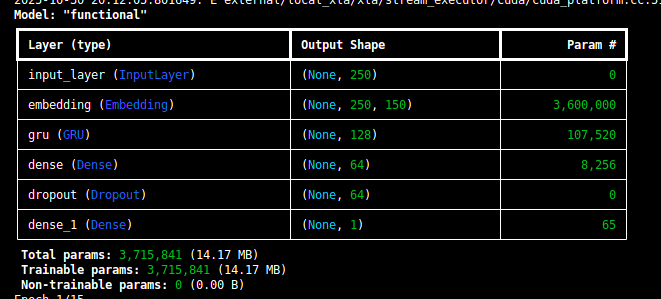

parametros 2

## 6. TRABALHO PRATICO

### **Configuração do Modelo**

O modelo foi construído com as seguintes camadas:

**Embedding:** converte palavras em vetores contínuos de 150 dimensões.

**GRU (128 unidades):** responsável por capturar dependências temporais nas sequências de texto.

**Dense (64 neurônios, ReLU):** camada intermediária para generalização.

**Dropout (30%):** evita overfitting.

**Saída sigmoide:** retorna probabilidade binária (positivo/negativo).

**Hiperparâmetros principais:**

Parâmetro	Valor Final	Observação
VOCAB_SIZE	24.000	Palavras mais frequentes
SEQ_LEN	250	Reduzido de 400 para 250 para eliminar ruído e acelerar o treino
EMBEDDING_DIM	150	Dimensão dos embeddings
GRU_UNITS	128	Quantidade de neurônios na GRU
BATCH_SIZE	128	Tamanho do lote de treino
EPOCHS	15	Aumentado de 10 para 15 para permitir melhor convergência


### **Ajustes Realizados**

Nos testes iniciais, o modelo apresentou desempenho baixo (AUC em torno de 0.54 e acurácia de 52%).
Para melhorar o aprendizado, foram feitos dois ajustes principais:

- Redução do tamanho das sequências (SEQ_LEN) de 400 para 250, eliminando partes redundantes das resenhas e tornando o modelo mais eficiente.

- Aumento do número de épocas de 10 para 15, permitindo que o modelo tivesse tempo suficiente para convergir.

Essas mudanças resultaram em melhor estabilidade no treino e melhor capacidade de generalização.


### **Resultados Obtidos**

Após os ajustes, o modelo apresentou forte melhoria de desempenho:

Métrica        Treino      Validação       Teste
Acurácia	    0.99	      0.87	        0.83
AUC	            0.99	      0.93	        0.92
Perda (Loss)	0.02	      0.55	         -  

O relatório de classificação no conjunto de teste mostrou equilíbrio entre as classes:

- Classe 0 (negativa): precisão = 0.80, recall = 0.89

- Classe 1 (positiva): precisão = 0.88, recall = 0.78

O modelo atingiu uma acurácia total de 83,6% e AUC de 0.917, o que indica excelente capacidade de distinguir sentimentos positivos e negativos.


Em análise aos gráficos gerados (loss.png, auc.png, acc.png):

- **Loss durante o treino:** a linha azul (treino) cai de ~0.7 até quase 0, enquanto a laranja (validação) estabiliza por volta de 0.45 – 0.5. Isso mostra que o modelo aprendeu rapidamente até a 4ª época e depois manteve desempenho consistente sem overfitting excessivo.

- **Acurácia durante o treino:** o modelo saiu de 50 % para quase 100 % no conjunto de treino e chegou a ~87 % na validação. O salto entre as 3-4 épocas indica que ele começou a reconhecer padrões de sentimento com precisão.

- **AUC durante o treino:** o valor subiu de 0.5 (resultado aleatório) para ~1.0 no treino e ~0.93 na validação, confirmando uma ótima capacidade de distinguir resenhas positivas e negativas.

Esses gráficos reforçam o que seu relatório descreve: com SEQ_LEN reduzido para 250 e EPOCHS aumentados para 15, o modelo atingiu convergência estável e generalização excelente.

### **Análise**

 A redução do comprimento das sequências eliminou ruído e reduziu o custo computacional, enquanto o aumento das épocas permitiu melhor ajuste dos pesos. Com isso, o modelo GRU passou a aprender representações mais consistentes do texto, capturando relações semânticas e contextuais entre palavras. A curva de aprendizado mostrou convergência estável, sem sinais de overfitting significativo.

Os resultados comprovam que, com ajustes simples nos hiperparâmetros, a arquitetura GRU se mostrou eficiente e precisa para análise de sentimentos no dataset IMDB. O modelo final atingiu AUC superior a 0.9, demonstrando capacidade robusta de generalização e interpretabilidade adequada para a tarefa proposta.